## Directories and Imports

In [1]:
%cd /content/drive/MyDrive/Stat Software/Project

/content/drive/MyDrive/Stat Software/Project


In [2]:
# install flair
!pip install flair

     |████████████████████████████████| 450kB 7.6MB/s 
     |████████████████████████████████| 1.3MB 13.1MB/s 
     |████████████████████████████████| 19.7MB 1.2MB/s 
     |████████████████████████████████| 71kB 12.4MB/s 
     |████████████████████████████████| 798kB 55.0MB/s 
     |████████████████████████████████| 983kB 52.1MB/s 
     |████████████████████████████████| 1.1MB 59.1MB/s 
     |████████████████████████████████| 2.9MB 63.5MB/s 
     |████████████████████████████████| 890kB 79.1MB/s 
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45612 sha256=90f12321bd18c6e17fa4d2ebee5ed6d734a95449d2add98fdd955ff9e539060e
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
  Created wheel for sqlitedict: filename=sqlitedict-1.7.0-cp36-none-any.whl size=14377 sha256=18a0ffe1ec8800b86e81e9e66e10458efdb2f371e16588e5de026026de9f0e0d
  Stored in directory: /root/.cache/pip/wheels/cf/c6/4f/2c64a43f041415eb8b8740bd80e15e9

In [4]:
import os
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

# plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# scikit
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

# flair
from flair.data import Corpus
from flair.datasets import ColumnCorpus
from flair.embeddings import TokenEmbeddings, WordEmbeddings, FlairEmbeddings, StackedEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from flair.data import Sentence
from flair.visual.training_curves import Plotter

In [5]:
# define directories
FINAL_DATA_DIR = os.path.join(os.getcwd(), 'final-data')
TRAIN_DATA = os.path.join(FINAL_DATA_DIR, 'ner-train.csv')
TEST_DATA = os.path.join(FINAL_DATA_DIR, 'ner-test.csv')
FLAIR_DATA_DIR = os.path.join(FINAL_DATA_DIR, 'flair-data')

In [6]:
df_train = pd.read_csv(TRAIN_DATA, header=None, names=['Sentence #', 'Word', 'POS', 'Tag', 'Word_Len'])
df_test = pd.read_csv(TEST_DATA, header=None, names=['Sentence #', 'Word', 'POS', 'Tag', 'Word_Len'])
df_train.head()

,Sentence #,Word,POS,Tag,Word_Len
0,Sentence: 1,Thousands,NNS,O,1
1,Sentence: 1,of,IN,O,1
2,Sentence: 1,demonstrators,NNS,O,1
3,Sentence: 1,have,VBP,O,1
4,Sentence: 1,marched,VBN,O,1


In [7]:
# train/val/test : 60/20/20 split

df_train.shape, df_test.shape

((875422, 5), (173153, 5))

## Prepare dataset for Flair training

In [8]:
train_inds, val_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(df_train, groups=df_train['Sentence #']))

# train_temp and val
train = df_train.iloc[train_inds]
val = df_train.iloc[val_inds]

train.reset_index(inplace=True)
val.reset_index(inplace=True)
df_test.reset_index(inplace=True)
#train_inds, test_inds = next(GroupShuffleSplit(test_size=.25, n_splits=2, random_state = 7).split(train_temp, groups=train_temp['Sentence #']))

# train and test
#train = train_temp.iloc[train_inds]
#test = train_temp.iloc[test_inds]

#train.reset_index(inplace=True)
#test.reset_index(inplace=True)

In [9]:
train.shape, val.shape, df_test.shape

((700843, 6), (174579, 6), (173153, 6))

In [10]:
def create_iob_for_flair(data, output_name):

  with open(FLAIR_DATA_DIR+'/'+output_name, 'w') as writefile:
    print(f"Preparing {output_name}...")
    for k, group in tqdm(data.groupby('Sentence #', sort=False)):

      for i, g in group.iterrows():
        string = g['Word'] + " " + g['Tag']
        writefile.write(string+'\n')
      writefile.write('\n')

In [ ]:
create_iob_for_flair(train, 'train_file.txt')
create_iob_for_flair(val, 'val_file.txt')
create_iob_for_flair(df_test, 'test_file.txt')

Preparing train_file.txt...



Preparing val_file.txt...



Preparing test_file.txt...


## Reading Sequence Labeling Dataset

In [11]:
# define columns
columns = {0: 'text', 1: 'ner'}

# init corpus
corpus: Corpus = ColumnCorpus(FLAIR_DATA_DIR, columns,
                              train_file='train_file.txt',
                              test_file='test_file.txt',
                              dev_file='val_file.txt')

2020-12-10 15:40:11,997 Reading data from /content/drive/My Drive/Stat Software/Project/final-data/flair-data
2020-12-10 15:40:11,998 Train: /content/drive/My Drive/Stat Software/Project/final-data/flair-data/train_file.txt
2020-12-10 15:40:11,999 Dev: /content/drive/My Drive/Stat Software/Project/final-data/flair-data/val_file.txt
2020-12-10 15:40:12,000 Test: /content/drive/My Drive/Stat Software/Project/final-data/flair-data/test_file.txt


In [12]:
# check corpus
len(corpus.train), len(corpus.dev), len(corpus.test)

(31999, 8000, 7960)

In [13]:
print(corpus.train[0].to_tagged_string('ner'))

Thousands of demonstrators have marched through London <B-geo> to protest the war in Iraq <B-geo> and demand the withdrawal of British <B-gpe> troops from that country .


In [14]:
print(corpus.dev[0].to_tagged_string('ner'))

Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush <B-per> Number One Terrorist " and " Stop the Bombings . "


In [15]:
print(corpus.test[0].to_tagged_string('ner'))

A company spokesman says the blast tore through a silo where refined sugar is kept .


In [16]:
print(corpus)

Corpus: 31999 train + 8000 dev + 7960 test sentences


## Training Flair

In [ ]:
# tag to predict
tag_type = 'ner'

# tag dict
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)

# init embeddings
embedding_types = [
                   FlairEmbeddings('news-forward'),
                   FlairEmbeddings('news-backward')
]

embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

# init sequence tagger
tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                        embeddings=embeddings,
                                        tag_dictionary=tag_dictionary,
                                        tag_type=tag_type,
                                        use_crf=True)

2020-12-02 15:58:18,523 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmpq0g41cnk


100%|██████████| 73034624/73034624 [00:01<00:00, 37318075.48B/s]

2020-12-02 15:58:20,543 copying /tmp/tmpq0g41cnk to cache at /root/.flair/embeddings/news-forward-0.4.1.pt


2020-12-02 15:58:20,613 removing temp file /tmp/tmpq0g41cnk
2020-12-02 15:58:27,177 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-backward-0.4.1.pt not found in cache, downloading to /tmp/tmp0lqve3s8


100%|██████████| 73034575/73034575 [00:01<00:00, 37233098.30B/s]

2020-12-02 15:58:29,203 copying /tmp/tmp0lqve3s8 to cache at /root/.flair/embeddings/news-backward-0.4.1.pt


2020-12-02 15:58:29,273 removing temp file /tmp/tmp0lqve3s8


In [ ]:
# init trainer
trainer: ModelTrainer = ModelTrainer(tagger,corpus)

# start training
trainer.train('resources/taggers/example-ner',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=150)

2020-12-02 15:58:39,359 ----------------------------------------------------------------------------------------------------
2020-12-02 15:58:39,361 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4096, out_features=4096, bias=True)
  (rnn): LSTM(4096, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_feature

{'dev_loss_history': [2.042276620864868,
  1.7470511198043823,
  1.6222668886184692,
  1.5646095275878906,
  1.5237905979156494,
  1.5110297203063965,
  1.4796046018600464,
  1.4510607719421387,
  1.4286305904388428,
  1.4169676303863525,
  1.4144632816314697,
  1.3989828824996948,
  1.3811283111572266,
  1.3858619928359985,
  1.385175347328186,
  1.3936140537261963,
  1.370165467262268,
  1.3340680599212646,
  1.3486398458480835,
  1.3431296348571777,
  1.3502817153930664,
  1.3525608777999878,
  1.3680555820465088,
  1.3346911668777466,
  1.3486441373825073,
  1.3386828899383545,
  1.335613489151001,
  1.3295966386795044,
  1.3585193157196045,
  1.3428009748458862,
  1.353545904159546,
  1.3594099283218384,
  1.3544507026672363,
  1.368391513824463,
  1.3374916315078735,
  1.3555576801300049,
  1.3545169830322266,
  1.3447339534759521,
  1.3905913829803467,
  1.354866862297058,
  1.3823764324188232,
  1.3799415826797485,
  1.3741967678070068,
  1.383279800415039,
  1.374310851097107,

2020-12-03 01:28:46,780 ----------------------------------------------------------------------------------------------------
2020-12-03 01:28:46,780 WARNING: No LOSS found for test split in this data.
2020-12-03 01:28:46,781 Are you sure you want to plot LOSS and not another value?
2020-12-03 01:28:46,781 ----------------------------------------------------------------------------------------------------
2020-12-03 01:28:46,801 ----------------------------------------------------------------------------------------------------
2020-12-03 01:28:46,801 WARNING: No F1 found for test split in this data.
2020-12-03 01:28:46,802 Are you sure you want to plot F1 and not another value?
2020-12-03 01:28:46,802 ----------------------------------------------------------------------------------------------------
Loss and F1 plots are saved in resources/taggers/example-ner/training.png


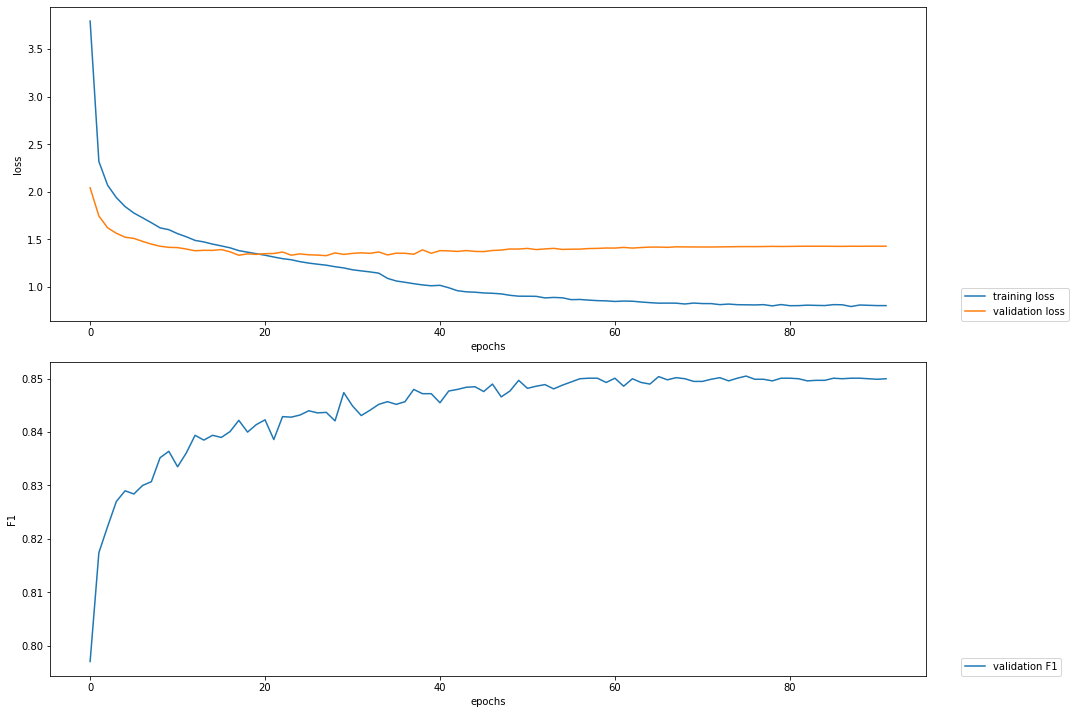

In [ ]:
plotter = Plotter()
plotter.plot_training_curves('resources/taggers/example-ner/loss.tsv')

## Inference

In [17]:
infer_sentences = ['The lands that today comprise Croatia were part of the Austro-Hungarian Empire until the close of World War I .',
                   "Much of New Orleans sits below sea level , and the levees ' failure during Hurricane Katrina put 80 percent of the city underwater .",
                   "A separate report says the number of people who lost jobs because of Hurricanes Katrina now exceeds $ 6,00,000 .",
                   "Google is in New York, London, Paris and Tokyo .",
                   "Our homework is due on Wednesday, February 1st .",
                   "Donald Trump is the president of United States .",
                   "I love Indian food ."]

In [18]:
# load trained model
model = SequenceTagger.load('resources/taggers/example-ner/final-model.pt')

print("Inference...\n")
for sent in infer_sentences:
  sentence = Sentence(sent)
  model.predict(sentence)
  print("-->", sentence.to_tagged_string())
  print()
# create example sentence
#sentence = Sentence(infer_sent)

# predict tags and print
#model.predict(sentence)

#print(sentence.to_tagged_string())

2020-12-10 15:42:49,174 loading file resources/taggers/example-ner/final-model.pt
Inference...

--> The lands that today comprise Croatia <B-geo> were part of the Austro-Hungarian Empire until the close of World <B-eve> War <I-eve> I <I-eve> .

--> Much of New <B-geo> Orleans <I-geo> sits below sea level , and the levees ' failure during Hurricane Katrina <B-nat> put 80 percent of the city underwater .

--> A separate report says the number of people who lost jobs because of Hurricanes <B-nat> Katrina <I-nat> now exceeds $ 6,00,000 .

--> Google <B-org> is in New <B-geo> York <I-geo> , London <B-geo> , Paris <B-geo> and Tokyo <B-geo> .

--> Our homework is due on Wednesday <B-tim> , February <B-tim> 1st <I-tim> .

--> Donald <B-per> Trump <I-per> is the president of United <B-geo> States <I-geo> .

--> I love Indian <B-gpe> food .



In [ ]:
# each token
for t in sentence.tokens:
  print(t.text)

I
love
Indian
food
.


In [ ]:
# tag
for t in sentence.tokens:
  print(t.get_tag('ner').to_dict()['value'])

O
O
B-gpe
O
O


## Evalaute on Flair

https://github.com/flairNLP/flair/issues/1105

In [20]:
# load the model to evaluate
tagger: SequenceTagger = SequenceTagger.load('resources/taggers/example-ner/best-model.pt')

# run evaluation procedure
result, score = tagger.evaluate(corpus.dev, mini_batch_size=32, out_path=f"predictions_val.txt")
print(result.detailed_results)

2020-12-10 15:45:44,150 loading file resources/taggers/example-ner/best-model.pt

Results:
- F1-score (micro) 0.8505
- F1-score (macro) 0.6955

By class:
art        tp: 16 - fp: 20 - fn: 46 - precision: 0.4444 - recall: 0.2581 - f1-score: 0.3265
eve        tp: 20 - fp: 17 - fn: 32 - precision: 0.5405 - recall: 0.3846 - f1-score: 0.4494
geo        tp: 5715 - fp: 971 - fn: 534 - precision: 0.8548 - recall: 0.9145 - f1-score: 0.8836
gpe        tp: 2460 - fp: 124 - fn: 185 - precision: 0.9520 - recall: 0.9301 - f1-score: 0.9409
nat        tp: 16 - fp: 12 - fn: 15 - precision: 0.5714 - recall: 0.5161 - f1-score: 0.5424
org        tp: 2441 - fp: 661 - fn: 985 - precision: 0.7869 - recall: 0.7125 - f1-score: 0.7479
per        tp: 2239 - fp: 612 - fn: 586 - precision: 0.7853 - recall: 0.7926 - f1-score: 0.7889
tim        tp: 2920 - fp: 353 - fn: 410 - precision: 0.8921 - recall: 0.8769 - f1-score: 0.8844


In [19]:
# load the model to evaluate
tagger: SequenceTagger = SequenceTagger.load('resources/taggers/example-ner/best-model.pt')

# run evaluation procedure
result, score = tagger.evaluate(corpus.test, mini_batch_size=32, out_path=f"predictions.txt")
print(result.detailed_results)

2020-12-10 15:43:28,083 loading file resources/taggers/example-ner/best-model.pt

Results:
- F1-score (micro) 0.8557
- F1-score (macro) 0.6831

By class:
art        tp: 12 - fp: 32 - fn: 63 - precision: 0.2727 - recall: 0.1600 - f1-score: 0.2017
eve        tp: 18 - fp: 22 - fn: 23 - precision: 0.4500 - recall: 0.4390 - f1-score: 0.4444
geo        tp: 5657 - fp: 893 - fn: 537 - precision: 0.8637 - recall: 0.9133 - f1-score: 0.8878
gpe        tp: 2634 - fp: 105 - fn: 123 - precision: 0.9617 - recall: 0.9554 - f1-score: 0.9585
nat        tp: 19 - fp: 15 - fn: 17 - precision: 0.5588 - recall: 0.5278 - f1-score: 0.5429
org        tp: 2432 - fp: 710 - fn: 968 - precision: 0.7740 - recall: 0.7153 - f1-score: 0.7435
per        tp: 2228 - fp: 551 - fn: 556 - precision: 0.8017 - recall: 0.8003 - f1-score: 0.8010
tim        tp: 2995 - fp: 342 - fn: 436 - precision: 0.8975 - recall: 0.8729 - f1-score: 0.8850


In [ ]:
print(result.detailed_results.expandtabs())


Results:
- F1-score (micro) 0.8557
- F1-score (macro) 0.6831

By class:
art        tp: 12 - fp: 32 - fn: 63 - precision: 0.2727 - recall: 0.1600 - f1-score: 0.2017
eve        tp: 18 - fp: 22 - fn: 23 - precision: 0.4500 - recall: 0.4390 - f1-score: 0.4444
geo        tp: 5657 - fp: 893 - fn: 537 - precision: 0.8637 - recall: 0.9133 - f1-score: 0.8878
gpe        tp: 2634 - fp: 105 - fn: 123 - precision: 0.9617 - recall: 0.9554 - f1-score: 0.9585
nat        tp: 19 - fp: 15 - fn: 17 - precision: 0.5588 - recall: 0.5278 - f1-score: 0.5429
org        tp: 2432 - fp: 710 - fn: 968 - precision: 0.7740 - recall: 0.7153 - f1-score: 0.7435
per        tp: 2228 - fp: 551 - fn: 556 - precision: 0.8017 - recall: 0.8003 - f1-score: 0.8010
tim        tp: 2995 - fp: 342 - fn: 436 - precision: 0.8975 - recall: 0.8729 - f1-score: 0.8850


In [35]:
1+1

2